In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

In [3]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print(len(text))

1115394


In [5]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
chars = sorted(list(set(text))) # all the unique chars in this text
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [7]:
# Tokenization 
# We simply create a mapping from char to int 
stoi = { ch:i for i,ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}

# Then, a way to encode and decode our chars/words/sentences
encode = lambda s: [stoi[ch] for ch in s] # takes a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # takes a list of integers, output a string

print(encode("hello world !"))
print(decode(encode("hello world !")))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 1, 2]
hello world !


In [8]:
# let's now tokenize the whole dataset
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:10])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [9]:
# Train/Test split

n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

len(train_data), len(test_data)

(1003854, 111540)

In [10]:
block_size = 8 # context window of chars
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
# Slowly creating/understanding our training dataset
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"input {context} target: {target}")

# we wan't the model to learn to generate from one char all the way to block_size chars

input tensor([18]) target: 47
input tensor([18, 47]) target: 56
input tensor([18, 47, 56]) target: 57
input tensor([18, 47, 56, 57]) target: 58
input tensor([18, 47, 56, 57, 58]) target: 1
input tensor([18, 47, 56, 57, 58,  1]) target: 15
input tensor([18, 47, 56, 57, 58,  1, 15]) target: 47
input tensor([18, 47, 56, 57, 58,  1, 15, 47]) target: 58


In [12]:
# let's create the batches 

batch_size = 4 # number of independant sequences processed in parallel
block_size = 8 # maximum context length for prediction

def get_batch(split):
    if split == 'train':
        data = train_data
    else:
        data = test_data
    
    ix = torch.randint(len(data) - block_size, (batch_size,)) # get batch_size random idx in the dataset
    x = torch.stack([data[i:i+block_size] for i in ix]) # for each ix, we get the block starting at this window and we stack them all
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # getting the targets by shifting the window by one
    return x,y

xb, yb = get_batch("train")
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('--------')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f'input {context.tolist()} target: {target}')

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
--------
input [24] target: 43
input [24, 43] target: 58
input [24, 43, 58] target: 5
input [24, 43, 58, 5] target: 57
input [24, 43, 58, 5, 57] target: 1
input [24, 43, 58, 5, 57, 1] target: 46
input [24, 43, 58, 5, 57, 1, 46] target: 43
input [24, 43, 58, 5, 57, 1, 46, 43] target: 39
input [44] target: 53
input [44, 53] target: 56
input [44, 53, 56] target: 1
input [44, 53, 56, 1] target: 58
input [44, 53, 56, 1, 58] target: 46
input [44, 53, 56, 1, 58, 46] target: 39
input [44, 53, 56, 1, 58, 46, 39] target: 58
input [44, 53, 56, 1, 58, 46, 39, 58] target: 1
input [52] target: 58
input [52, 58] ta

In [13]:
# Before implementing a transformer, we start with a bigram model

# Note : 
# B --> batch, T --> time, C --> channel
# time is for the context (words come sequentially)
# channel is the embedding dim (vocab_size here)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) 

    def forward(self, idx, targets=None):
        #idx and targets are both (B,T) tensor of ints
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            # PB : the cross entropy loss wan'ts a (B,C,T)
            # Fix : we reshape the logits
            B,T,C = logits.shape # unpacking the shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) # it must only be a 1D vector
            loss = F.cross_entropy(logits, targets)
        return logits, loss 
    
    def generate(self, idx, max_new_tokens):
        # for now this generate fct is overkill 
        # We are feeding it with all the context but it's useless as its a bigram model 
        # Still, we implement it like this so that it will be unchanged for transformers

        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx) # get the preds
            # focus only on the last time step (i.e last char)
            logits = logits[:, -1, :] # becomes (B,C) bc it's only one embedded char for each sequence in the batch
            probs = F.softmax(logits, dim=1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1) choose one for each sequence in the batch
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
m = BigramLanguageModel(vocab_size)
out, loss = m(xb, yb)
print(out.shape) # (B,T,C) = (batch_size, block_size, vocab_size)
print(loss)

torch.Size([32, 65])


tensor(5.0364, grad_fn=<NllLossBackward0>)


In [14]:
# visualize the reshape of logits and targets : 
# making sure the dimensions are right 
print(xb.shape) # (B,T) = (4,8)
logits = m.token_embedding_table(xb) # (B,T,C) = (4,8,65)
B,T,C = logits.shape
print(B,T,C)
print(logits.view(B*T,C).shape) # (BT, C) = (32,65)

# from a list of matrices of embedded char sequences
# to a matrice of embedded char sequences 
# i.e we concatenate 
print(logits[1][0]) # second matrice, first embedding
print(logits.view(B*T,C)[8]) # embedding on row 9 i.e same  
# it's really a concatenation or stacking of the batches so that we can use the cross entropy loss


torch.Size([4, 8])
4 8 65
torch.Size([32, 65])
tensor([-0.3173, -2.2339, -1.4059,  1.2754,  0.3269,  0.4072,  0.9861, -1.3452,
        -0.0214, -0.0606,  0.8196,  0.9585, -1.5620, -0.9595,  1.8561,  0.1731,
        -0.6004, -0.1511, -0.2633, -0.2980, -0.6959,  0.8446,  2.3401,  0.5713,
         0.7937, -2.2403, -0.0907,  0.3705, -0.1498,  0.3753, -0.2322, -0.6855,
        -1.2521,  0.8792, -0.9479, -0.9450, -1.6462, -1.6728, -0.7227, -0.1755,
        -0.2187, -1.6041,  0.9001,  0.4649, -0.1040,  1.0264,  1.6527, -0.1772,
        -0.3859,  0.9534, -1.7580, -0.1748,  0.2244, -0.1926,  0.2210,  0.7663,
        -0.5540, -0.2526,  0.2016, -0.3885,  1.3035,  0.6635,  0.2673, -0.0410,
         1.0837], grad_fn=<SelectBackward0>)
tensor([-0.3173, -2.2339, -1.4059,  1.2754,  0.3269,  0.4072,  0.9861, -1.3452,
        -0.0214, -0.0606,  0.8196,  0.9585, -1.5620, -0.9595,  1.8561,  0.1731,
        -0.6004, -0.1511, -0.2633, -0.2980, -0.6959,  0.8446,  2.3401,  0.5713,
         0.7937, -2.2403, -0

In [15]:
-torch.log(torch.tensor(1/vocab_size)) # cross entropy if the prior is uniform (as it should be)
# It's lower than the current loss so it's not good
# we can resolve that by initalizing proprely but we won't do it here as it's just a baseline model

tensor(4.1744)

In [16]:
# Let's generate from the model 
idx = torch.zeros((1,1), dtype=torch.long) # just a zero tensor 
# zero represents a newline char in our dict so it's coherent to use it as a first char

generated_idx = m.generate(idx, max_new_tokens=100)[0].tolist() # [0] because we access the "single batch"
print(decode(generated_idx))


l-QYjt'CL?jLDuQcLzy'RIo;'KdhpV
vLixa,nswYZwLEPS'ptIZqOZJ$CA$zy-QTkeMk x.gQSFCLg!iW3fO!3DGXAqTsq3pdgq


In [17]:
m.generate(idx, max_new_tokens=100).shape

torch.Size([1, 101])

In [18]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [19]:
print(m.parameters)

<bound method Module.parameters of BigramLanguageModel(
  (token_embedding_table): Embedding(65, 65)
)>


In [20]:
# training loop 
batch_size = 32

for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.416266441345215


In [21]:
# let's see how much we improved
idx = torch.zeros((1,1), dtype=torch.long) 
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))
# It's way better that above (at initialization)
# But its still terrible


BRouthe sssit ey
KINld pe wither vouprroutherccnohathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so itJas
Waketancotha:
h hay.JUCLUKn prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZEESTEORDY:
h l.
KEONGBUCHandspo be y,-JZNEEYowddy scace, tridesar, wnl'shenous s 


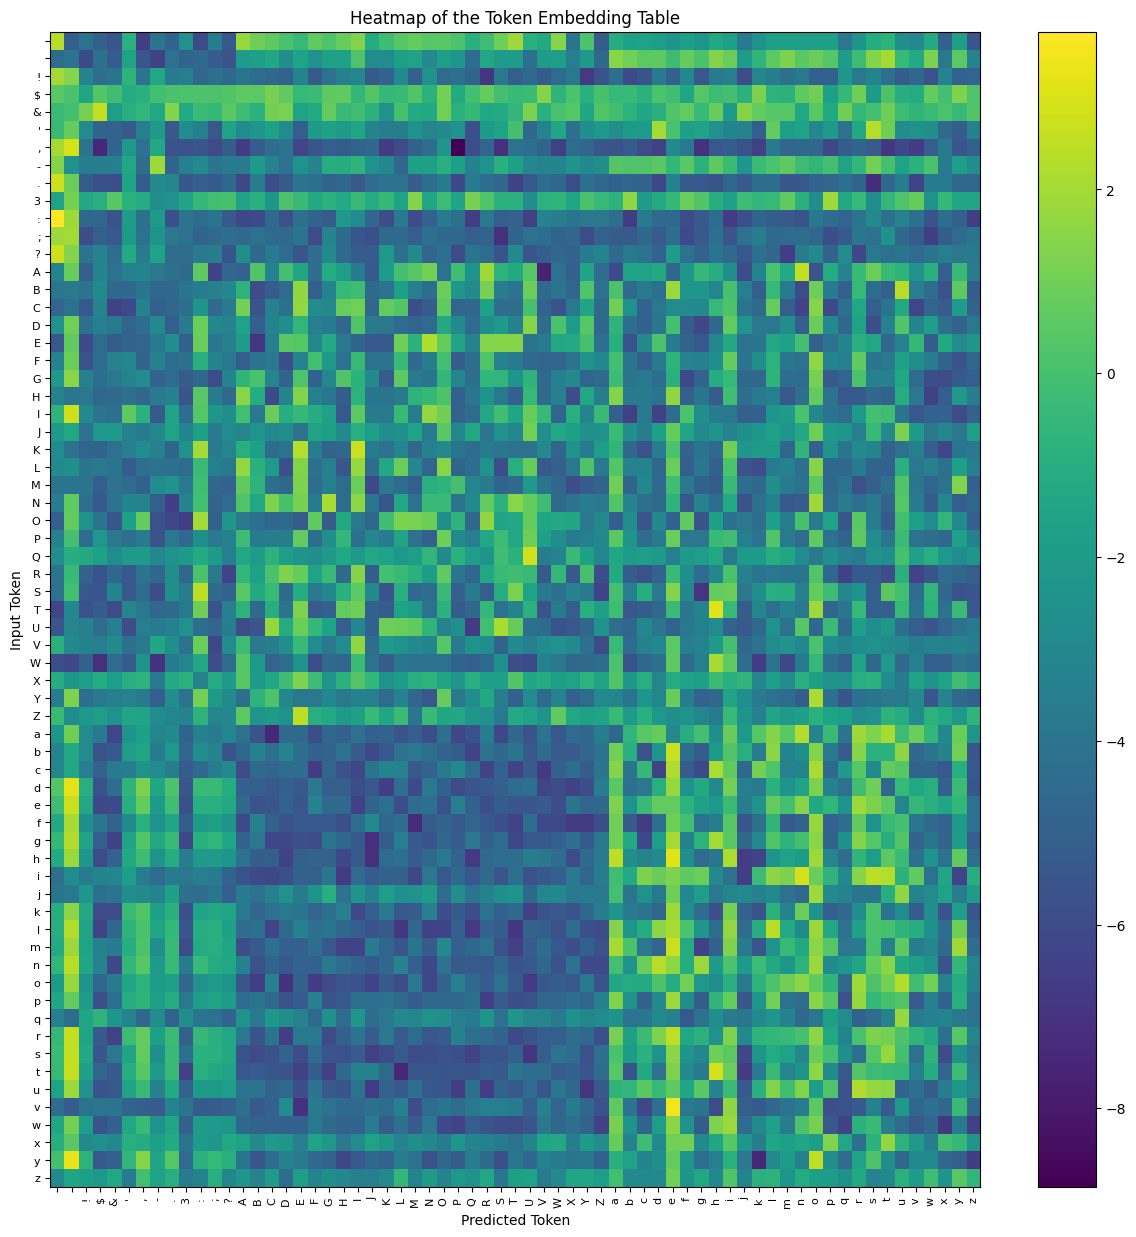

In [22]:
import numpy as np

import matplotlib.pyplot as plt

# Get the weight matrix from our embedding table
weights = m.token_embedding_table.weight.detach().cpu().numpy()

plt.figure(figsize=(15, 15))
plt.imshow(weights, cmap='viridis', aspect='auto')
plt.colorbar()

# Label rows and columns using itos (index-to-char mapping)
plt.xticks(ticks=np.arange(vocab_size), labels=[itos[i] for i in range(vocab_size)], rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(vocab_size), labels=[itos[i] for i in range(vocab_size)], fontsize=8)

plt.xlabel("Predicted Token")
plt.ylabel("Input Token")
plt.title("Heatmap of the Token Embedding Table")
plt.show()

In [23]:
print(logits.shape)

torch.Size([256, 65])


# Let's start the GPT implementation. 

### The mathematical trick in self-attention

In [24]:
# consider the following toy example:
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# version 1:
# One way to use the context is to take the average of the previous chars:
xbow = torch.zeros((B,T,C)) # bow : bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

x[0], xbow[0] # each line of the xbow[0] is the avg of the previous lines of x[0]

(tensor([[-0.1978,  0.5817],
         [ 0.3381, -0.3723],
         [-0.1780,  0.0046],
         [-1.9912, -1.1509],
         [ 0.1407,  2.4141],
         [-1.1666,  1.3247],
         [ 0.6259,  0.0284],
         [-1.5851, -1.2515]]),
 tensor([[-0.1978,  0.5817],
         [ 0.0701,  0.1047],
         [-0.0126,  0.0713],
         [-0.5072, -0.2342],
         [-0.3776,  0.2954],
         [-0.5091,  0.4670],
         [-0.3470,  0.4043],
         [-0.5017,  0.1973]]))

In [ ]:
# The trick is that we can do that very efficiently using matrix multiplication 
a = torch.tril(torch.ones(3,3))
b = torch.randint(0,10,(3,2)).float()
c = a @ b

print(a)
print(b)
print(c)

# for each line of c, we have the vertical sum of the previous lines of b 

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
tensor([[8., 4.],
        [9., 3.],
        [3., 5.]])
tensor([[ 8.,  4.],
        [17.,  7.],
        [20., 12.]])


In [ ]:
# to go from sum to avg, we simply normalize a
a = a / torch.sum(a,1,keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b

print(a)
print(b)
print(c) # it's the avg as we wanted

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[4., 6.],
        [7., 9.],
        [2., 2.]])
tensor([[4.0000, 6.0000],
        [5.5000, 7.5000],
        [4.3333, 5.6667]])


In [ ]:
# version 2:
# Let's apply that to our bow 
wei = torch.tril(torch.ones(T,T)) # wei for weights
wei = wei/wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T,T) @ (B,T,C) --> (B,T,C)
# pytorch will see that there is a dim missing so (T,T) --> (B,T,T)
# and it will perform the matrix mul for each batch in parallel
# i.e for each batch, we multiply a (T,T) @ (T,C) just as above 
torch.allclose(xbow, xbow2) # they are equal 

True

In [40]:
xbow[0], xbow2[0]

(tensor([[-0.1978,  0.5817],
         [ 0.0701,  0.1047],
         [-0.0126,  0.0713],
         [-0.5072, -0.2342],
         [-0.3776,  0.2954],
         [-0.5091,  0.4670],
         [-0.3470,  0.4043],
         [-0.5017,  0.1973]]),
 tensor([[-0.1978,  0.5817],
         [ 0.0701,  0.1047],
         [-0.0126,  0.0713],
         [-0.5072, -0.2342],
         [-0.3776,  0.2954],
         [-0.5091,  0.4670],
         [-0.3470,  0.4043],
         [-0.5017,  0.1973]]))

In [ ]:
# we have a third version for the same thing using SOFTMAX
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # every element that is 0 in tril, replace it with -inf
print(tril)
print(wei) # wei is now a triangular sup matrix with only -inf

# What happens if we take a softmax of that ? 
# it will normalize it with -inf --> 0 and the rest is uniform (only zeros) so they will get the same weight
# remember, we exponentiate and divide by their exp sum
F.softmax(wei, dim=-1) # same as before as excpected

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
# version 3
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

# it's better because : 
# The weights tell us how much tokens from the past do we wan't to agregate (avg)
# adding the -inf make sure that we are not using the future 
# then we aggregate using the mat mul
# here, we set the initial weights at 0, but the idea is that they will be data dependant to give more or less important to certain terms (affinities)
# it will be learned by the network
# and the aggregation will be weighted depending on these affinities

True

### first self attention head:

Of course, we don't wan't the weights to be uniform. Because different tokens will find different tokens more interesting.

ex: if i'm a vowel, i wan't to know consonantes in my past and i wan't this information to flow to me

i.e I wan't info about the past in a data dependant way

This is the problem SELF ATTENTION solves

### The attention mechanism

every single token at each position, will emit two vectores : a query and a key
- the query is a vector that represents the token's interest in other tokens (i.e what do i want to know about the past)
- the key is a vector that represents the token's importance to other tokens (i.e what do i contain or have to offer)

The way we get affinities between tokens is by taking the dot product between the query and the key of each token.
- the dot product is a measure of similarity between two vectors. The higher the dot product, the more similar the two vectors are.
- the dot product is a measure of how much one vector is interested in the other vector. The higher the dot product, the more interested the first vector is in the second vector.

The value is a vector that represents the token's content. The value is what the token contains and what it has to offer to other tokens.

In [ ]:
# version 4: self-attention
B,T,C = 4,8,32
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B,T,16)
q = query(x) # (B,T,16)
# at this point, no communication happened between the tokens
# now it does:
wei = q @ k.transpose(-2,-1) # -2 is T, -1 is head_size, (B,T,16) @ (B,16,T) --> (B,T,T)
print(f"wei of first batch after dot products \n {wei[0]}")

tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
print(f"wei wei of first batch after masking \n {wei[0]}")
wei = F.softmax(wei, dim=-1)
print(f"final wei of first batch after softmax \n {wei[0]}")
print("we then mutliply it with x to get the aggregations")
print(f"here is the first batch of x: \n {x[0]}")

v = value(x)
out = wei @ x
print(f"the output for the first batch: \n {out[0]}")
out.shape
# when the affinities are all 0, the aggregation is simply an average

wei of first batch after dot products 
 tensor([[-0.8966, -1.8894,  3.5351,  0.2947, -1.5164,  2.0977, -1.3926,  2.0678],
        [ 0.6637,  0.9359, -0.9747,  0.2244,  0.9913, -1.9044,  0.5182, -0.1868],
        [ 1.8779, -0.3505,  0.3955,  0.7281,  0.0439,  0.3371,  1.1918,  0.5955],
        [ 1.4644,  1.1218,  1.0131, -0.7729, -0.4541,  0.5597,  0.9235,  2.6931],
        [ 0.6715, -2.5817, -1.0222,  0.1735, -0.9825,  0.0513,  0.7877, -0.3711],
        [ 1.0661, -0.2105,  1.0341,  0.1928,  0.9869, -0.0388,  2.1724, -0.8251],
        [ 1.7248,  0.6385, -0.8306,  0.5162, -1.1670,  0.2840, -0.0848,  0.6850],
        [ 0.8194, -0.4705,  0.2894, -0.1186,  0.0915, -1.5042,  1.3332, -0.3514]],
       grad_fn=<SelectBackward0>)
wei wei of first batch after masking 
 tensor([[-0.8966,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.6637,  0.9359,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 1.8779, -0.3505,  0.3955,    -inf,    -inf,    -inf,    

torch.Size([4, 8, 32])